In [3]:
import datetime
import sys
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense

In [4]:
# tf.config.threading.set_intra_op_parallelism_threads(
#     7
# )
# tf.config.threading.set_inter_op_parallelism_threads(
#     7
# )

print(tf.__version__)

2.3.2


# Contents
- [Load data](#Load-data)
- [NLP model](#NLP-Model)
- [Investigating saliency](#Investigating-saliency)

# Load data

In [5]:
data_file = Path("/home/alexander/projects/car_data_analysis/final_project_data/deduped_data.csv")

data = pd.read_csv(data_file)
data = data[["id","desc","price"]]

train, test = train_test_split(data, test_size=0.3)
print(f"{len(train)}-{len(test)}")

24381-10450


In [6]:
train.loc[:,"test"] = 0
test.loc[:,"test"] = 1

/home/alexander/projects/gta/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/alexander/projects/gta/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [7]:
data = pd.concat((train, test))
data.tail()

,id,desc,price,test
6399,33-99,"LOW RATE FINANCE AVAILABLE, 0% DEPOSIT FINANCE...",6495,1
18712,84-234,"Really nice example of a ""Black Edition"" 420d ...",9649,1
28408,136-31,"TRADING STANDARD APPROVED DEALER, Over 100 car...",8599,1
23274,102-453,RECENT FULL SERVICE WITH TIMING BELT KIT & WAT...,7995,1
29273,140-108,"Fsh, exellent driver, all documents present, d...",1295,1


In [166]:
m = max(data["desc"])
print(m)
sample = tf.constant(max(data["desc"]))
sample

🚗🚙 Another Quality Vehicle Available From Qa Cars Ltd!🚗🚙 , 2009 Skoda Fabia Tdi 12M MOT+ 12M WARRANTY+12M BREAKDOWN - £1,295, ◼ 1.9, Diesel, Manual , ◼ 138932 Miles, All Vehicles Come With 12 Months MOT,  12 Months Warranty & 12 Months Breakdown Cover,  💰 LOW RATE FINANCE AVAILABLE,  🚗 ANY VEHICLE TAKEN IN PART EXCHANGE,  🚚 DELIVERY SERVICE AVAILABLE, 🎥 VIDEO VIEWINGS AVAILABLE,  💊 ALL VEHICLES ARE FULLY VALETED & SANITISED, 💬 Contact Us Today !!, ☎ 07759212301, 🌐 www.Qacars.co.uk, 🖥 Full Details, Specification & Photos Can Be Found At:www.Qacars.co.uk , Grey, 5+ owners, £1,295


<tf.Tensor: shape=(), dtype=string, numpy=b'\xf0\x9f\x9a\x97\xf0\x9f\x9a\x99 Another Quality Vehicle Available From Qa Cars Ltd!\xf0\x9f\x9a\x97\xf0\x9f\x9a\x99 , 2009 Skoda Fabia Tdi 12M MOT+ 12M WARRANTY+12M BREAKDOWN - \xc2\xa31,295, \xe2\x97\xbc 1.9, Diesel, Manual , \xe2\x97\xbc 138932 Miles, All Vehicles Come With 12 Months MOT,  12 Months Warranty & 12 Months Breakdown Cover,  \xf0\x9f\x92\xb0 LOW RATE FINANCE AVAILABLE,  \xf0\x9f\x9a\x97 ANY VEHICLE TAKEN IN PART EXCHANGE,  \xf0\x9f\x9a\x9a DELIVERY SERVICE AVAILABLE, \xf0\x9f\x8e\xa5 VIDEO VIEWINGS AVAILABLE,  \xf0\x9f\x92\x8a ALL VEHICLES ARE FULLY VALETED & SANITISED, \xf0\x9f\x92\xac Contact Us Today !!, \xe2\x98\x8e 07759212301, \xf0\x9f\x8c\x90 www.Qacars.co.uk, \xf0\x9f\x96\xa5 Full Details, Specification & Photos Can Be Found At:www.Qacars.co.uk , Grey, 5+ owners, \xc2\xa31,295'>

# NLP Model

In [183]:
# Extra handling: emojis - markdown etc.

def lower_strip_punc_and_no_nums(inputs):
    lowercase_inputs = tf.strings.lower(inputs)
    DEFAULT_STRIP_REGEX = r'[!"#$£%&()\+,-\./:;<=>?@\[\\\]^_`{|}~\']+'
    inputs = tf.strings.regex_replace(lowercase_inputs, DEFAULT_STRIP_REGEX, "")
    bold_regex = r'[\*]+'
    inputs = tf.strings.regex_replace(inputs, bold_regex, " ")
#     inputs = tf.strings.regex_replace(inputs, r"[0-9]*", "")
    inputs = tf.strings.regex_replace(inputs, r"[,|0-9]*$", "")
    return inputs

lower_strip_punc_and_no_nums(sample)

<tf.Tensor: shape=(), dtype=string, numpy=b'\xf0\x9f\x9a\x97\xf0\x9f\x9a\x99 another quality vehicle available from qa cars ltd\xf0\x9f\x9a\x97\xf0\x9f\x9a\x99  2009 skoda fabia tdi 12m mot 12m warranty12m breakdown  1295 \xe2\x97\xbc 19 diesel manual  \xe2\x97\xbc 138932 miles all vehicles come with 12 months mot  12 months warranty  12 months breakdown cover  \xf0\x9f\x92\xb0 low rate finance available  \xf0\x9f\x9a\x97 any vehicle taken in part exchange  \xf0\x9f\x9a\x9a delivery service available \xf0\x9f\x8e\xa5 video viewings available  \xf0\x9f\x92\x8a all vehicles are fully valeted  sanitised \xf0\x9f\x92\xac contact us today  \xe2\x98\x8e 07759212301 \xf0\x9f\x8c\x90 wwwqacarscouk \xf0\x9f\x96\xa5 full details specification  photos can be found atwwwqacarscouk  grey 5 owners '>

In [184]:
VOCAB_SIZE = 5000

text_input = Input(shape=(), dtype=tf.string, name='text')
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(output_mode='tf-idf', 
            standardize=lower_strip_punc_and_no_nums, 
            max_tokens=5000)
encoder.adapt(train["desc"].values)
net = encoder(text_input)
net = Dense(64, activation="relu")(net)
net = Dense(32, activation="relu")(net)
net = Dense(1, activation="relu")(net)

model = tf.keras.Model(text_input, net)

In [185]:
model.summary()


Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None,)]                 0         
_________________________________________________________________
text_vectorization_6 (TextVe (None, 5000)              0         
ctorization)                                                     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                320064    
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 327,177
Trainable params: 322,177
Non-trainable params: 5,000
_________________________________________________________________


In [186]:
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(train) // BATCH_SIZE
boundaries = [30*STEPS_PER_EPOCH, 50*STEPS_PER_EPOCH]
values = [0.001, 1e-5, 1e-8]
lr = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

loss = keras.losses.MeanSquaredError()
optim = tf.keras.optimizers.RMSprop(learning_rate=lr)

model.compile(loss=loss, optimizer=optim)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

In [187]:
start = datetime.datetime.now()
history = model.fit(train["desc"].values, 
                    train["price"].values,
                    epochs=100,
                    batch_size=BATCH_SIZE,
                    validation_data=(test["desc"].values, test["price"].values),
                    callbacks=[early_stopping],
                    verbose=1,
                   )
end = datetime.datetime.now()
time_elapsed = (end - start).total_seconds()
print(f"{time_elapsed} seconds")

Epoch 1/100
381/381 [==============================] - 18s 48ms/step - loss: 25444996.0000 - val_loss: 16238399.0000
Epoch 2/100
381/381 [==============================] - 17s 44ms/step - loss: 13707459.0000 - val_loss: 11258168.0000
Epoch 3/100
381/381 [==============================] - 17s 44ms/step - loss: 9457258.0000 - val_loss: 8561622.0000
Epoch 4/100
381/381 [==============================] - 17s 44ms/step - loss: 7255330.5000 - val_loss: 7095678.5000
Epoch 5/100
381/381 [==============================] - 17s 44ms/step - loss: 5912070.5000 - val_loss: 6226949.5000
Epoch 6/100
381/381 [==============================] - 17s 44ms/step - loss: 5099227.0000 - val_loss: 5772105.0000
Epoch 7/100
381/381 [==============================] - 17s 45ms/step - loss: 4612621.5000 - val_loss: 5534150.0000
Epoch 8/100
381/381 [==============================] - 17s 44ms/step - loss: 4293700.5000 - val_loss: 5362701.0000
Epoch 9/100
381/381 [==============================] - 17s 45ms/step - loss:

# Investigating saliency

## Retrieve some samples from data and encode

In [188]:
train_desc = tf.constant(data[data["test"]==0].iloc[2]["desc"])
train_desc_batched = tf.expand_dims(tf.constant(train_desc), axis=0)
test_desc = tf.constant(data[data["test"]==1].iloc[4]["desc"])
test_desc_batched = tf.expand_dims(tf.constant(test_desc), axis=0)
print(train_desc.numpy())
print("-"*100)
print(test_desc.numpy())

b'A solid mechanically sound car, that has been a pleasure to own. Selling due to buying a new car* 9 Service stamps - last service done in November 2020*New exhaust system replaced in November 2020*MOT valid till Dec 2021*Paintwork damage to right rear bumper (See pictures). Few chips in other areas but given its age in good condition*4 Pirelli tyres with good thread*Spare tyre with jack and bolt nut*3 previous owners*Drivers wing mirror replaced hence reason for different colour. Original wing mirror still available*CD player*Power Steering*Aircon*Isofix fittings on rear seats*Good Interior - few scuff marks and general wear and tear*Spare wheel with fixing nut and jack*Road tax 205 per year*159 g/km*1398cc* ULEZ CompliantViewings available after 5pm Monday to Friday and any time on Saturday and Sunday***No Time Wasters Please** **BACS PAYMENT ONLY** NO CASH, Smoke free, Pet free Blue, 4 owners, \xc2\xa31,350'
--------------------------------------------------------------------------

In [189]:
train_encoding = encoder(train_desc_batched)
verify_encoding = encoder(train_desc)
test_encoding = encoder(test_desc_batched)
print(train_encoding)
print(test_encoding)
lower_strip_punc_and_no_nums(train_desc)

tf.Tensor([[4.8250613 5.3297615 0.        ... 0.        0.        0.       ]], shape=(1, 5000), dtype=float32)
tf.Tensor([[ 5.629238 11.547816 17.194803 ...  0.        0.        0.      ]], shape=(1, 5000), dtype=float32)


<tf.Tensor: shape=(), dtype=string, numpy=b'a solid mechanically sound car that has been a pleasure to own selling due to buying a new car  9 service stamps  last service done in november 2020 new exhaust system replaced in november 2020 mot valid till dec 2021 paintwork damage to right rear bumper see pictures few chips in other areas but given its age in good condition 4 pirelli tyres with good thread spare tyre with jack and bolt nut 3 previous owners drivers wing mirror replaced hence reason for different colour original wing mirror still available cd player power steering aircon isofix fittings on rear seats good interior  few scuff marks and general wear and tear spare wheel with fixing nut and jack road tax 205 per year 159 gkm 1398cc  ulez compliantviewings available after 5pm monday to friday and any time on saturday and sunday no time wasters please   bacs payment only  no cash smoke free pet free blue 4 owners '>

### Helper functions

In [190]:
vocab = encoder.get_vocabulary()
import numpy as np
import re

def index_encoding(text, encoder):
    """
    Returns an array with the encoding indexes of each of the words in the text provided.
    """
    indices = []
    if isinstance(text, bytes):
        text = text.decode("UTF-8")
    text = re.sub(r'[!"#$£%&()\+,-\./:;<=>?@\[\\\]^_`{|}~\']*','', text)
    text = re.sub(r'\*',' ', text)
    text = re.sub(r'[,|0-9]*$','', text)
    for word in text.split(" "):
        encoding = encoder(word)
        if len(encoding) != 0:
            encoding = encoder(word).numpy()
            non_zero = np.nonzero(encoding)
            if len(non_zero) == 2:
                index = int(non_zero[1][0])
            elif len(non_zero) == 1:
                index = 0
            else:
                raise ValueError()
        else:
            print((word, encoding))
            index = None
        indices.append((word, index))        
    return indices

## Retrieve trained Dense layers - as we want saliency on encoded words

In [191]:
encoded_input = Input(shape=(5000,))
net = encoded_input

for layer in model.layers[-3:]:
    net = layer(net)
saliency_model = tf.keras.Model(encoded_input, net)
saliency_model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5000)]            0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                320064    
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 322,177
Trainable params: 322,177
Non-trainable params: 0
_________________________________________________________________


In [192]:
saliency_res = saliency_model(train_encoding)
model_res = model(train_desc_batched)
print(saliency_res)
print(model_res)

tf.Tensor([[2054.1804]], shape=(1, 1), dtype=float32)
tf.Tensor([[2054.1804]], shape=(1, 1), dtype=float32)


In [193]:
with tf.GradientTape() as tape:
    tape.watch(train_encoding)
    tape.watch(train_desc_batched)
    saliency_res = saliency_model(train_encoding)
    model_res = model(train_desc_batched)

encoded_saliency = tape.gradient(saliency_res, train_encoding).numpy()[0]
print(encoded_saliency)
# direct_saliency = tape.gradient(model_res, train_desc_batched)

[ 21.960205   10.02275    -1.481833  ... -63.547768   37.503876
   1.6277921]


In [194]:
def map_to_unit(grads):
    _max = grads.max()
    _min = grads.min()
#     return [(grad-_min)/(_max- _min) for grad in grads]
    return [abs(grad)/abs(_max) for grad in grads]

highlight_intensity = map_to_unit(encoded_saliency)
highlight_intensity[0]

0.053083662

('', <tf.Tensor: shape=(0, 5000), dtype=float32, numpy=array([], shape=(0, 5000), dtype=float32)>)
('9', <tf.Tensor: shape=(0, 5000), dtype=float32, numpy=array([], shape=(0, 5000), dtype=float32)>)
('', <tf.Tensor: shape=(0, 5000), dtype=float32, numpy=array([], shape=(0, 5000), dtype=float32)>)
('2020', <tf.Tensor: shape=(0, 5000), dtype=float32, numpy=array([], shape=(0, 5000), dtype=float32)>)
('2020', <tf.Tensor: shape=(0, 5000), dtype=float32, numpy=array([], shape=(0, 5000), dtype=float32)>)
('2021', <tf.Tensor: shape=(0, 5000), dtype=float32, numpy=array([], shape=(0, 5000), dtype=float32)>)
('4', <tf.Tensor: shape=(0, 5000), dtype=float32, numpy=array([], shape=(0, 5000), dtype=float32)>)
('3', <tf.Tensor: shape=(0, 5000), dtype=float32, numpy=array([], shape=(0, 5000), dtype=float32)>)
('', <tf.Tensor: shape=(0, 5000), dtype=float32, numpy=array([], shape=(0, 5000), dtype=float32)>)
('205', <tf.Tensor: shape=(0, 5000), dtype=float32, numpy=array([], shape=(0, 5000), dtype=flo

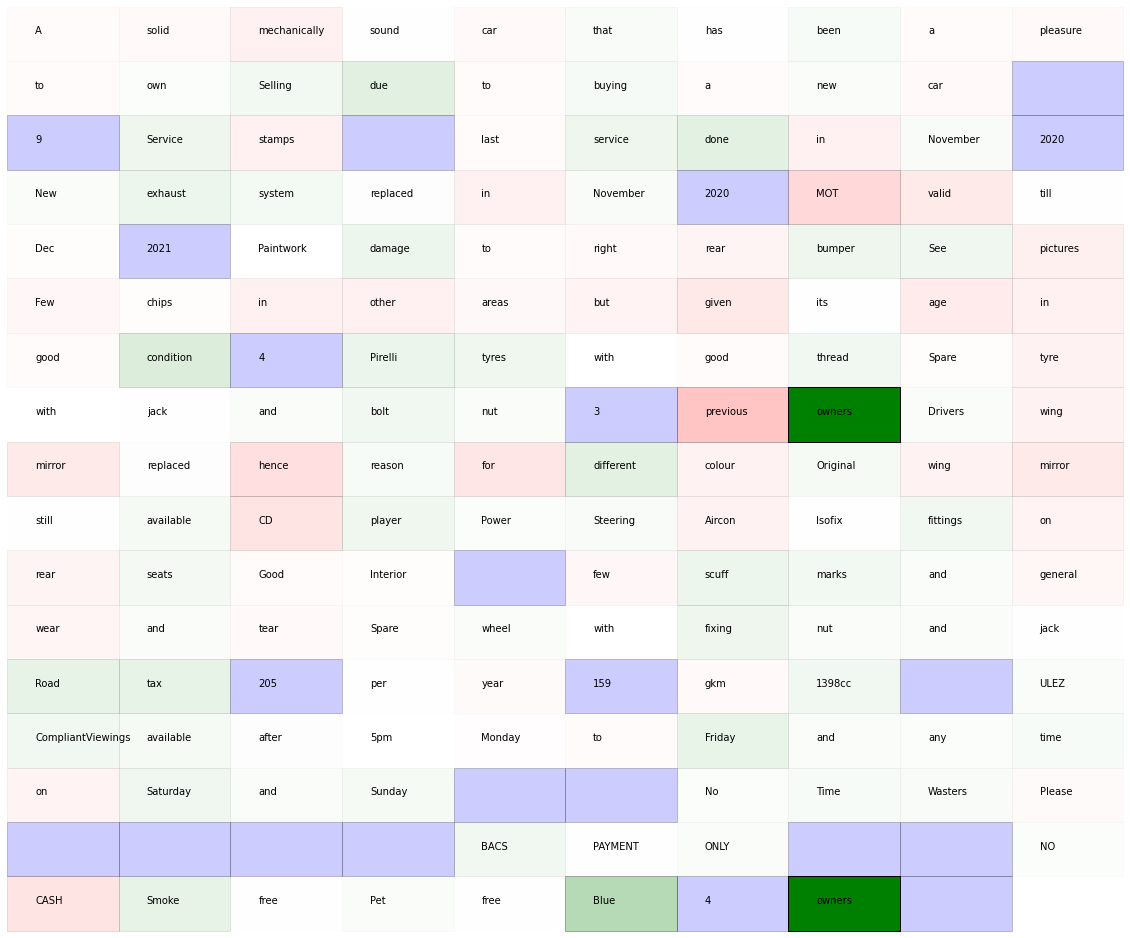

In [195]:
text, indices = list(zip(*index_encoding(train_desc.numpy(), encoder)))
absent_highlight_intensity = 0.2
alphas = [highlight_intensity[idx] if idx is not None else absent_highlight_intensity for idx in indices]

# Could do this feeding in different samples and across words
# 

def get_grad(word, grads, v=False):
    a = index_encoding(word, encoder)
    if v:
        print(f"encoding indices: {a}")
    if a[0][1] is not None:
        # e.g. encoding exists
        b = [x for x in a if x[0] == word]
        if len(b) != 1:
            # We should only have a one encoding of a single word
            raise ValueError(b)
        b = b[0]
        return grads[b[1]]
    else:
        return "No encoding"

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from typing import Iterable

def text_saliency(text: Iterable, alphas: Iterable, height=None, width=20, word_width=2):
    if height is None:
        height = len(text)//(width//word_width) + 1
    
    def highlight(x, y, intensity=0.2, word_width=word_width, col="g"):
        pc = [Rectangle((x-0.5, y-0.5), word_width, 1)]
        pc = PatchCollection(pc, facecolor=col, alpha=intensity,
                             edgecolor="black")
        plt.gca().add_collection(pc)
    
    plt.figure(figsize=(width,height))
    plt.axis("off")
    plt.axis([0, width, 0, height])
    loc = [0.5, height-0.5]
    for word, alpha in zip(text, alphas):
        grad = get_grad(word, encoded_saliency)
        if isinstance(grad, str):
            col = "b"
        elif grad >= 0:
            col = "g"
        else:
            col = "r"
        highlight(*loc, intensity=alpha, col=col)
        loc = list(plt.text(*loc, word).get_position())
        loc[0] += word_width
        if loc[0] > width:
            loc[0] = 0.5
            loc[1] -=1

text_saliency(text, alphas)

In [200]:
for word in ["Red", "Blue", "Black", "White"]:
    print(get_grad(word, encoded_saliency, v=True))

encoding indices: [('Red', 143)]
115.41999
encoding indices: [('Blue', 83)]
119.276886
encoding indices: [('Black', 25)]
222.02962
encoding indices: [('White', 112)]
176.50497


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[112013.6]], dtype=float32)>

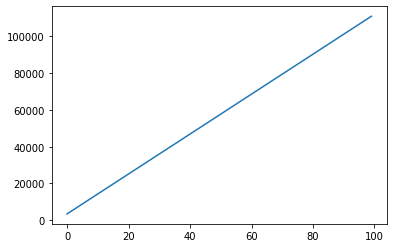

In [218]:
scale = 100
word_scaling = [tf.squeeze(model(tf.constant("owners "*x)[tf.newaxis,...])) for x in range(scale)]
plt.plot(range(scale), word_scaling)

model(tf.constant("owners "*100)[tf.newaxis,...])